In [1]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/SkinCare'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import datetime as dt
import pickle
import torch
import json
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from MLP_Nets import MLP_Nets

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from usefull_functions import *
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [2]:
image_label = 'binary_label'  #[image_label, binary_label]

file = 'CNN_280x210_Ouput_binary' 
data = pd.read_pickle(G_path + '/CNN_Output/' + file)

blc_test_list = pickle.load(open(G_path + '/blc_test_meta_list','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data[image_label]
train_data = train_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
test_label = test_data[image_label]
test_data = test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])

train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

# **Random Forrest**

In [3]:
Model_ = sk.ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat =1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [20,30],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [False],
    'class_weight' : [None, 'balanced'],
    'max_leaf_nodes' : [5,None],
}

RF_Model, RF_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(RF_Model, open(G_path + '/Saved/Models/Classifiers/' + 'RF_Model_binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 640/640
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       290
           1       0.72      0.74      0.73       117

    accuracy                           0.84       407
   macro avg       0.81      0.81      0.81       407
weighted avg       0.84      0.84      0.84       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'max_leaf_nodes': None, 'n_estimators': 200}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8427518427518428


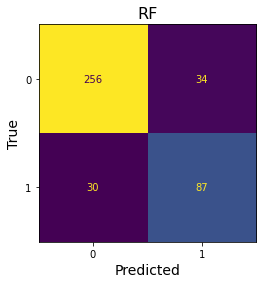

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,89.5%,88.3%,74.4%,88.9%
1,28.7%,71.9%,74.4%,88.3%,73.1%
Simple Avg.,nan%,80.7%,81.3%,81.3%,81.0%
Weighted Avg.,nan%,84.4%,84.3%,78.4%,84.4%


In [4]:
# Model 280x210
model_ = RF_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'RF')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [5]:
Model_ = sk.ensemble.RandomForestClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [20],
    'criterion' :['gini'],
    'bootstrap': [False],
    'class_weight' : [None,],
    'max_leaf_nodes' : [None],
}

RF_Model_CV, RF_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(RF_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'RF_Model_CV_binary' , 'wb'))
    pickle.dump(RF_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'RF_Model_CV_binary' , 'wb'))


------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       290
           1       0.69      0.73      0.71       117

    accuracy                           0.83       407
   macro avg       0.79      0.80      0.79       407
weighted avg       0.83      0.83      0.83       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}


# **SVM**

In [6]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [10]
    ,'kernel': ['rbf', 'linear'],
    'degree' : [1,3,7],
    'gamma' :['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight' : [None, 'balanced']
}

SVM_Model, SVM_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat = nr_repeat)

if save_model:
    pickle.dump(SVM_Model, open(G_path + '/Saved/Models/Classifiers/' + 'SVM_Model_Binary' , 'wb'))
    

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 480/480
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       290
           1       0.65      0.82      0.73       117

    accuracy                           0.82       407
   macro avg       0.79      0.82      0.80       407
weighted avg       0.84      0.82      0.83       407

Best param:  {'C': 10, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8230958230958231


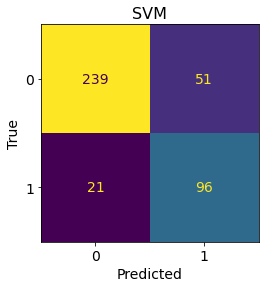

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,91.9%,82.4%,82.1%,86.9%
1,28.7%,65.3%,82.1%,82.4%,72.7%
Simple Avg.,nan%,78.6%,82.2%,82.2%,79.8%
Weighted Avg.,nan%,84.3%,82.3%,82.2%,82.8%


In [7]:
# Model 280x210
model_ = SVM_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'SVM')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

In [8]:
sk.metrics.roc_auc_score(Y,Y_pred)

0.8223253757736516

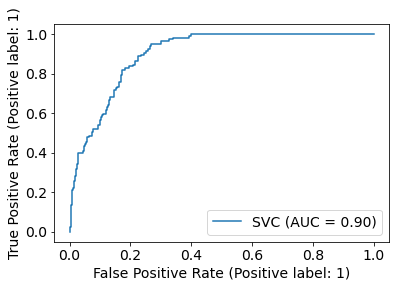

In [9]:

sk.metrics.plot_roc_curve(SVM_Model, X, Y) 

**Cross Validation**

In [10]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [10]
    ,'kernel': ['rbf'],
    'degree' : [1],
    'gamma' :['scale'],
    'decision_function_shape': ['ovo'],
    'class_weight' : [None]
}

SVM_Model_CV, SVM_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(SVM_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'SVM_Model_CV_Binary' , 'wb'))
    pickle.dump(SVM_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'SVM_Model_CV_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       290
           1       0.67      0.71      0.69       117

    accuracy                           0.82       407
   macro avg       0.77      0.78      0.78       407
weighted avg       0.82      0.82      0.82       407

Best param:  {'C': 10, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8230958230958231


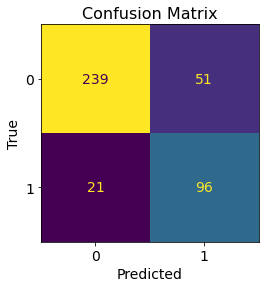

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,91.9%,82.4%,82.1%,86.9%
1,28.7%,65.3%,82.1%,82.4%,72.7%
Simple Avg.,nan%,78.6%,82.2%,82.2%,79.8%
Weighted Avg.,nan%,84.3%,82.3%,82.2%,82.8%


In [11]:
# Model 280x210
model_ = SVM_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results

# **Guassian NB**

In [12]:
Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_mode = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [0,4e-1,5e-1,3e-1, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

GB_Model, GB_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=1)

if save_model:
    pickle.dump(GB_Model, open(G_path + '/Saved/Models/Classifiers/' + 'GB_Model_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 170/170
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       290
           1       0.59      0.86      0.70       117

    accuracy                           0.79       407
   macro avg       0.76      0.81      0.77       407
weighted avg       0.83      0.79      0.80       407

Best param:  {'priors': None, 'var_smoothing': 0.5}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7886977886977887


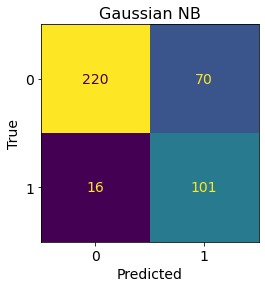

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,93.2%,75.9%,86.3%,83.7%
1,28.7%,59.1%,86.3%,75.9%,70.1%
Simple Avg.,nan%,76.1%,81.1%,81.1%,76.9%
Weighted Avg.,nan%,83.4%,78.9%,83.3%,79.8%


In [13]:
# Model 280x210
model_ = GB_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'Gaussian NB')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [14]:
Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_mode = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [5e-1]
}

GB_Model_CV, GB_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=10)

if save_model:
    pickle.dump(GB_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'GB_Model_CV_Binary' , 'wb'))
    pickle.dump(GB_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'GB_Model_CV_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       290
           1       0.59      0.86      0.70       117

    accuracy                           0.79       407
   macro avg       0.76      0.81      0.77       407
weighted avg       0.84      0.79      0.80       407

Best param:  {'priors': None, 'var_smoothing': 0.5}


# **MLP**

In [16]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : 10.00 ** -np.arange(2, 4)
}

MLP_Model, MLP_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model, open(G_path + '/Saved/Models/Classifiers/' + 'MLP_Model_Binary' , 'wb'))
    

------- Precision recal %--------.................................................................................] 4/40
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       290
           1       0.67      0.72      0.69       117

    accuracy                           0.82       407
   macro avg       0.77      0.79      0.78       407
weighted avg       0.82      0.82      0.82       407

Best param:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 60, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'random_state': 0, 'solver': 'sgd'}


**Cross Validation**

In [17]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [1e-2]
}

MLP_Model_CV, MLP_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'MLP_Model_CV_Binary' , 'wb'))
    pickle.dump(MLP_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'MLP_Model_CV_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       290
           1       0.69      0.73      0.71       117

    accuracy                           0.83       407
   macro avg       0.79      0.80      0.79       407
weighted avg       0.83      0.83      0.83       407

Best param:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 60, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'random_state': 0, 'solver': 'sgd'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8157248157248157


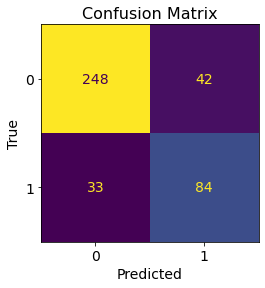

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,88.3%,85.5%,71.8%,86.9%
1,28.7%,66.7%,71.8%,85.5%,69.1%
Simple Avg.,nan%,77.5%,78.7%,78.7%,78.0%
Weighted Avg.,nan%,82.0%,81.6%,75.7%,81.8%


In [18]:
# Model 280x210
model_ = MLP_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results

# **KNN**

In [19]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [5,7,8,10,16],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'leaf_size' : [15,20,25],
    'p' : [1,2,5]
}

KNN_Model, KNN_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model, open(G_path + '/Saved/Models/Classifiers/' + 'KNN_Model_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 3600/3600
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       290
           1       0.68      0.69      0.68       117

    accuracy                           0.82       407
   macro avg       0.77      0.78      0.78       407
weighted avg       0.82      0.82      0.82       407

Best param:  {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


**Cross Validation**

In [20]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [8],
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size' : [25],
    'p' : [2]
}

KNN_Model_CV, KNN_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'KNN_Model_CV_Binary' , 'wb'))
    pickle.dump(KNN_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'KNN_Model_CV_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       290
           1       0.67      0.68      0.67       117

    accuracy                           0.81       407
   macro avg       0.77      0.77      0.77       407
weighted avg       0.81      0.81      0.81       407

Best param:  {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8157248157248157


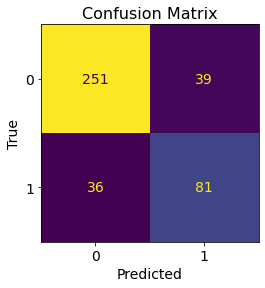

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,87.5%,86.6%,69.2%,87.0%
1,28.7%,67.5%,69.2%,86.6%,68.4%
Simple Avg.,nan%,77.5%,77.9%,77.9%,77.7%
Weighted Avg.,nan%,81.7%,81.6%,74.2%,81.6%


In [21]:
# Model 280x210
model_ = KNN_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results

# **Biased Classifier**

In [22]:
Dum_class = sk.dummy.DummyClassifier(strategy="most_frequent" )

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

Dum_class.fit(X_train, Y_train)

Y = Y_test
Y_pred = Dum_class.predict(X_test)

print(sk.metrics.classification_report(Y,Y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       290
           1       0.00      0.00      0.00       117

    accuracy                           0.71       407
   macro avg       0.36      0.50      0.42       407
weighted avg       0.51      0.71      0.59       407



In [23]:
Model_ = sk.dummy.DummyClassifier(strategy="most_frequent" )
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {}

Biased_Model_CV, Biased_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(Biased_Model_CV, open(G_path + '/Saved/Models/Classifiers/' + 'Biased_Model_CV_Binary' , 'wb'))
    pickle.dump(Biased_Details_CV, open(G_path + '/Saved/Cross_Valid_Results/' + 'Biased_Model_CV_Binary' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       290
           1       0.00      0.00      0.00       117

    accuracy                           0.71       407
   macro avg       0.36      0.50      0.42       407
weighted avg       0.51      0.71      0.59       407

Best param:  {}


In [24]:
CNN_Rescaled_Details = pickle.load(open(G_path + '/Saved/Cross_Valid_Results/' + 'CNN_Rescaled_Details_Binary' ,'rb'))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


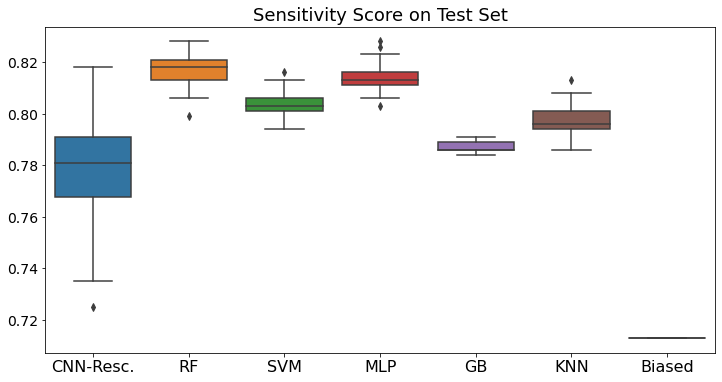

In [ ]:
c = 'test_recall_weighed'
df = [CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

Sensitivity = df_0
plt.subplots(figsize=(12,6))
sns.boxplot(data=Sensitivity)
plt.title('Sensitivity Score on Test Set (Binary classification)',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

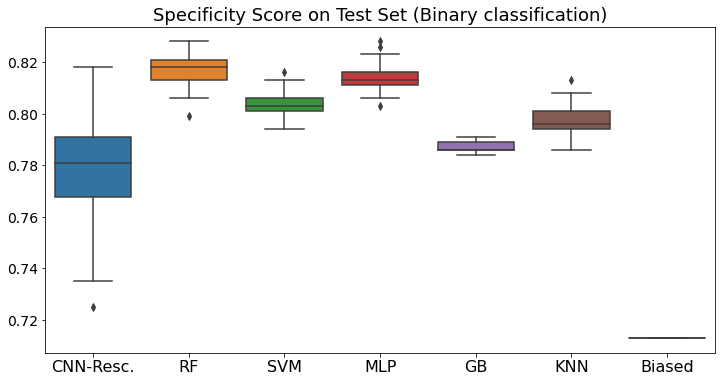

In [ ]:
c = 'test_specificity_weighed'
df = [CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

specificity = df_0
plt.subplots(figsize=(12,6))
sns.boxplot(data=specificity)
plt.title('Specificity Score on Test Set (Binary classification)',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

In [ ]:
pd.DataFrame(specificity.mean())

,0
CNN-Resc.,0.75740
RF,0.75087
SVM,0.73565
MLP,0.74888
GB,0.82879
KNN,0.71698
Biased,0.28700


In [ ]:
pd.DataFrame(specificity.std()) 

,0
CNN-Resc.,4.382945e-02
RF,9.693958e-03
SVM,6.527912e-03
MLP,8.495132e-03
GB,2.705382e-03
KNN,9.481486e-03
Biased,5.579081e-17
